In [1]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn.model_selection as sk
from sklearn.utils import shuffle
import random
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score,roc_auc_score

C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# get input data from Keras datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# combine x_train and x_test for later pre-processing
X = np.vstack([x_train,x_test])
y = np.append(y_train,y_test)

In [3]:
# split data by categories of 6 and 4 items
# create test2 and training dara
training_images_lab = {0:"top", 1:"trouser", 2:"pullover", 4:"coat", 5:"sandal", 9:"ankle boot"}
unseen_image_lab = {3:"dress", 7:"sneaker", 8:"bag", 6:"shirt"}
X_train = []
y_train = []
X_test = []
y_test = []
for index in range(len(y)):    
    if y[index] in training_images_lab.keys():
        X_train.append(X[index])
        y_train.append(y[index])
    else:
        X_test.append(X[index])
        y_test.append(y[index])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test2 = np.array(X_test)
y_test2 = np.array(y_test)

In [4]:
# split training data into training and test1
X_train, X_test1, y_train, y_test1 = sk.train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# union test1 and test2
X_test3, y_test3 = np.concatenate([X_test1, X_test2]), np.concatenate([y_test1, y_test2])

In [5]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    x: image data
    digit_indices: location of data which arrange by categories
    '''
    pairs = []
    labels = []
    # n: minimum pairs that we can create in all category 
    n = min([len(digit_indices[d]) for d in range(len(digit_indices))]) - 1
    for d in range(len(digit_indices)):
        for i in range(n):
            # Postive Pairs
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # Negative Pairs, randomly pick on in other category 
            inc = random.randrange(1, len(digit_indices))
            dn = (d + inc) % len(digit_indices)
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [0, 1]
    return np.array(pairs), np.array(labels)

In [6]:
# Training data - 80%
digit_indices = [np.where(y_train == i)[0] for i in list(training_images_lab.keys())]
train_x, train_y = create_pairs(X_train, digit_indices)
# Test 1 - 20% 
digit_indices = [np.where(y_test1 == i)[0] for i in list(training_images_lab.keys())]
test_x1, test_y1 = create_pairs(X_test1, digit_indices)
# Test 2 - 4 categories 
digit_indices = [np.where(y_test2 == i)[0] for i in list(unseen_image_lab.keys())]
test_x2, test_y2 = create_pairs(X_test2, digit_indices)
# Test 3 - Test1 Union Test2
all_images = list(training_images_lab.keys())+list(unseen_image_lab.keys())
digit_indices = [np.where(y_test3 == i)[0] for i in all_images]
test_x3, test_y3 = create_pairs(X_test3, digit_indices)

In [7]:
# fig, ax = plt.subplots(nrows=10, ncols=4,figsize=(40, 40))
# idx = 0
# for row in range(10):
#     idx = random.randrange(0,len(train_pairs),2)
#     ax[row,0].imshow(train_pairs[idx][0],cmap = 'gray')
#     ax[row,1].imshow(train_pairs[idx][1],cmap = 'gray')
#     idx+=1
#     ax[row,2].imshow(train_pairs[idx][0],cmap = 'gray')
#     ax[row,3].imshow(train_pairs[idx][1],cmap = 'gray')
# plt.show()

In [8]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [9]:
# Normalize train and test data
train_x = train_x.astype('float32')/255
test_x1 = test_x1.astype('float32')/255
test_x2 = test_x2.astype('float32')/255
test_x3 = test_x3.astype('float32')/255

In [10]:
# Reshape into (n, 2, 28, 28, 1)
# where n is number of examples
# img_rows and img_cols are the size of data
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0], 2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0], 2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0], 2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [11]:
# split training data into train and validation for training
train_x, val_x, train_y, val_y = sk.train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [12]:
def euclidean_distance(vects):
    '''
    compute the euclidean distance between a and b
    which a and b are ouput from two embedding layers
    the representation of embedding is highly dimensional    
    '''
    a, b = vects
    sum_square = K.sum(K.square(a - b), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    #return the shape of embedding output
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred, m = 1):
    '''
    y_pred: the distance which computed by eclidean distance
    y_true: ground truth, 1: same category, 0: different category
    m: margin which compute if a pair is in same region

    for a postive pair, we want the embedding presentation points are in a region
    for a negative pair, we want the embedding presentation points are outside the region
    
    the loss function can be split into 2 part:
    Positive pair loss1: D(Pi,Pj)^2 , where y_true = 0
    Negative pair loss2: max(0, m - D(Pi,Pj))^2  , where y_true = 1
    
    Here, we remove 1/2, cuz it's redundant
    '''
    
#   y_ture == 0
    loss1 = tf.cast(K.equal(y_true,0),dtype = 'float32') * K.square(y_pred)
#   y_ture == 1
    loss2 = tf.cast(K.equal(y_true,1),dtype = 'float32') * K.square(K.maximum(m - y_pred, 0))
    return K.mean(loss1 + loss2)


def accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold (0.5) on distance.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

In [13]:
def create_base_network(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation='relu',name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [14]:
def create_base_network_emb2(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', name = 'embeding')(x) 
    output = Dense(128, activation='relu',name = 'embeding2')(x)    
    
    return Model(input_tensor, output)

In [15]:
# create siamese network 
def siamese_model(input_shape,cnn_base_network):
    base_network = cnn_base_network
    base_network.summary()
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    # because we re-use the same instance `base_network`,
    # the weights of the network will be shared across the two networks
    embedding_a = base_network(input_a)
    embedding_b = base_network(input_b)
    # compute the distance of embadding layer
    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([embedding_a, embedding_b])

    model = Model([input_a, input_b], distance)
    model.summary()
    
    return model

In [16]:
def plot_loss_accuracy(history,parameter):
    print("Tuning :"+parameter)
    loss = history.history['loss'].copy()
    val_loss= history.history['val_loss'].copy()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss','Validation loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Tuning:"+parameter+" loss")
    plt.savefig('./images/'+parameter+'_loss.png', bbox_inches='tight')
    plt.show()
    plt.close()
    accuracy = history.history['accuracy'].copy()
    val_accuracy = history.history['val_accuracy'].copy()
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Tuning :"+parameter+" accuracy")
    plt.savefig('./images/'+parameter+'_accuracy.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [17]:
def evaluate_test_accuracy_roc(model,model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3):
    print("Tuning :"+model_name)
    pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
    pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
    pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

    te_acc1 = accuracy_score(test_y1, pred1>0.5)
    te_acc2 = accuracy_score(test_y2, pred2>0.5)
    te_acc3 = accuracy_score(test_y3, pred3>0.5)
    print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
    print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
    print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

    model.save('./Data/model'+model_name+'.h5')
    
    # analyse precision and recall
    print(classification_report(test_y1,pred1>0.5))
    print(classification_report(test_y2,pred2>0.5))
    
    # print confusion matrix
    print("Confusion Matrix")
    print(confusion_matrix(test_y2,pred2>0.5))
    
    
    # plot ROC curve
    fpr_rf1, tpr_rf1, _ = roc_curve(test_y1, pred1)
    fpr_rf2, tpr_rf2, _ = roc_curve(test_y2, pred2)
    fpr_rf3, tpr_rf3, _ = roc_curve(test_y3, pred3)
    
    roc_index1 = roc_auc_score(test_y1, pred1)
    roc_index2 = roc_auc_score(test_y2, pred2)
    roc_index3 = roc_auc_score(test_y3, pred3)  
    
    plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf1, tpr_rf1, label='test1 {:.3f}'.format(roc_index1))
    plt.plot(fpr_rf2, tpr_rf2, label='test2 {:.3f}'.format(roc_index2))
    plt.plot(fpr_rf3, tpr_rf3, label='test3 {:.3f}'.format(roc_index3))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve '+ model_name)
    plt.legend(loc='best')
    plt.savefig('./images/'+'roc_curve_'+model_name+'.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [18]:
select_base_arch=create_base_network(input_shape)
model=siamese_model(input_shape,select_base_arch)

W1024 18:28:14.546550 10544 deprecation.py:506] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0     

In [19]:
model_name='lr_1e-4_emb_1'

# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

W1024 18:28:14.790029 10544 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 7s 115us/sample - loss: 0.1649 - accuracy: 0.7612 - val_loss: 0.1200 - val_accuracy: 0.8550
Epoch 2/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.1084 - accuracy: 0.8751 - val_loss: 0.0979 - val_accuracy: 0.8923
Epoch 3/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0901 - accuracy: 0.9044 - val_loss: 0.0842 - val_accuracy: 0.9084
Epoch 4/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0784 - accuracy: 0.9172 - val_loss: 0.0747 - val_accuracy: 0.9167
Epoch 5/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0700 - accuracy: 0.9260 - val_loss: 0.0678 - val_accuracy: 0.9266
Epoch 6/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0643 - accuracy: 0.9318 - val_loss: 0.0631 - val_accuracy: 0.9309
Epoch 7/200
60145/60145 [=========================

Epoch 55/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0322 - accuracy: 0.9670 - val_loss: 0.0336 - val_accuracy: 0.9615
Epoch 56/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0319 - accuracy: 0.9669 - val_loss: 0.0337 - val_accuracy: 0.9629
Epoch 57/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0317 - accuracy: 0.9671 - val_loss: 0.0333 - val_accuracy: 0.9632
Epoch 58/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0316 - accuracy: 0.9674 - val_loss: 0.0336 - val_accuracy: 0.9641
Epoch 59/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0314 - accuracy: 0.9678 - val_loss: 0.0329 - val_accuracy: 0.9626
Epoch 60/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0311 - accuracy: 0.9687 - val_loss: 0.0328 - val_accuracy: 0.9632
Epoch 61/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0309 - ac

60145/60145 [==============================] - 4s 64us/sample - loss: 0.0195 - accuracy: 0.9858 - val_loss: 0.0243 - val_accuracy: 0.9779
Epoch 163/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0194 - accuracy: 0.9861 - val_loss: 0.0249 - val_accuracy: 0.9777
Epoch 164/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0196 - accuracy: 0.9856 - val_loss: 0.0242 - val_accuracy: 0.9783
Epoch 165/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0193 - accuracy: 0.9860 - val_loss: 0.0242 - val_accuracy: 0.9791
Epoch 166/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0193 - accuracy: 0.9861 - val_loss: 0.0242 - val_accuracy: 0.9791
Epoch 167/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0192 - accuracy: 0.9860 - val_loss: 0.0242 - val_accuracy: 0.9795
Epoch 168/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0191 - accuracy:

Tuning :lr_1e-4_emb_1


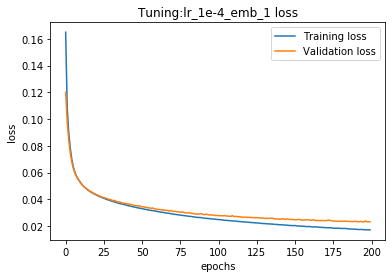

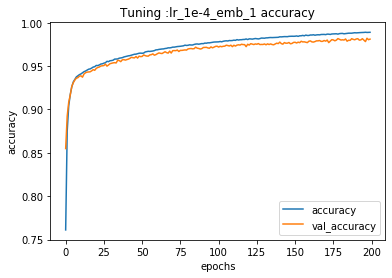

Tuning :lr_1e-4_emb_1
* Accuracy on test1 set: 96.70%
* Accuracy on test2 set: 67.07%
* Accuracy on test3 set: 82.79%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8238
           1       0.96      0.98      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.76      0.49      0.60     27996
           1       0.63      0.85      0.72     27996

    accuracy                           0.67     55992
   macro avg       0.70      0.67      0.66     55992
weighted avg       0.70      0.67      0.66     55992

Confusion Matrix
[[13803 14193]
 [ 4246 23750]]


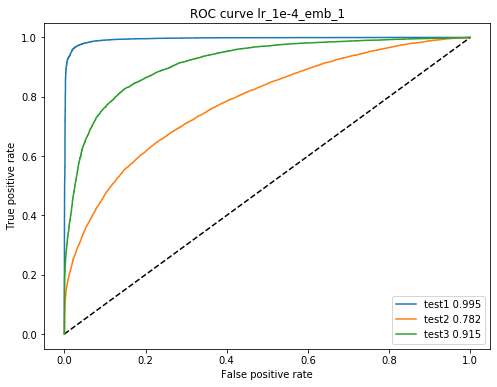

In [20]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [21]:
select_base_arch=create_base_network_emb2(input_shape)
model=siamese_model(input_shape,select_base_arch)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

In [22]:
model_name='lr_1e-4_emb_2'

# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 4s 70us/sample - loss: 0.2287 - accuracy: 0.6639 - val_loss: 0.1300 - val_accuracy: 0.8328
Epoch 2/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.1134 - accuracy: 0.8541 - val_loss: 0.1007 - val_accuracy: 0.8809
Epoch 3/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0917 - accuracy: 0.8973 - val_loss: 0.0857 - val_accuracy: 0.9049
Epoch 4/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0789 - accuracy: 0.9150 - val_loss: 0.0750 - val_accuracy: 0.9176
Epoch 5/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0700 - accuracy: 0.9255 - val_loss: 0.0674 - val_accuracy: 0.9250
Epoch 6/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0639 - accuracy: 0.9314 - val_loss: 0.0623 - val_accuracy: 0.9322
Epoch 7/200
60145/60145 [==========================

Epoch 55/200
60145/60145 [==============================] - 4s 68us/sample - loss: 0.0234 - accuracy: 0.9784 - val_loss: 0.0261 - val_accuracy: 0.9730
Epoch 56/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0230 - accuracy: 0.9789 - val_loss: 0.0258 - val_accuracy: 0.9735
Epoch 57/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0229 - accuracy: 0.9795 - val_loss: 0.0257 - val_accuracy: 0.9732
Epoch 58/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0226 - accuracy: 0.9796 - val_loss: 0.0255 - val_accuracy: 0.9742
Epoch 59/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0222 - accuracy: 0.9803 - val_loss: 0.0254 - val_accuracy: 0.9752
Epoch 60/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0220 - accuracy: 0.9805 - val_loss: 0.0249 - val_accuracy: 0.9744
Epoch 61/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0216 - ac

Epoch 163/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0060 - accuracy: 0.9966 - val_loss: 0.0122 - val_accuracy: 0.9888
Epoch 164/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0059 - accuracy: 0.9967 - val_loss: 0.0123 - val_accuracy: 0.9877
Epoch 165/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0058 - accuracy: 0.9966 - val_loss: 0.0122 - val_accuracy: 0.9888
Epoch 166/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0059 - accuracy: 0.9966 - val_loss: 0.0123 - val_accuracy: 0.9889
Epoch 167/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0058 - accuracy: 0.9966 - val_loss: 0.0118 - val_accuracy: 0.9887
Epoch 168/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0057 - accuracy: 0.9967 - val_loss: 0.0119 - val_accuracy: 0.9888
Epoch 169/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.00

Tuning :lr_1e-4_emb_2


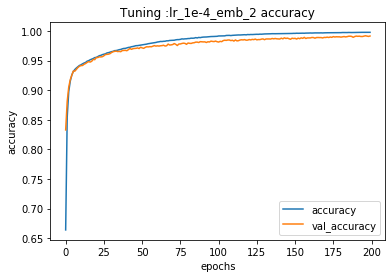

Tuning :lr_1e-4_emb_2
* Accuracy on test1 set: 96.36%
* Accuracy on test2 set: 64.46%
* Accuracy on test3 set: 81.54%
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      8238
           1       0.94      0.99      0.96      8238

    accuracy                           0.96     16476
   macro avg       0.96      0.96      0.96     16476
weighted avg       0.96      0.96      0.96     16476

              precision    recall  f1-score   support

           0       0.76      0.42      0.54     27996
           1       0.60      0.86      0.71     27996

    accuracy                           0.64     55992
   macro avg       0.68      0.64      0.63     55992
weighted avg       0.68      0.64      0.63     55992

Confusion Matrix
[[11881 16115]
 [ 3787 24209]]


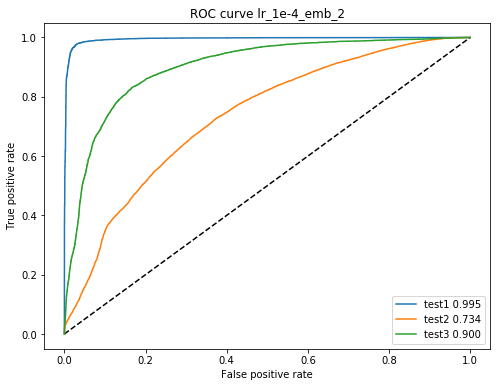

In [23]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [24]:
def create_base_network_drop_2(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(128, activation='relu',name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [25]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

model_name='RELU_lr_1e-4_drop'

# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 4s 65us/sample - loss: 0.0301 - accuracy: 0.9711 - val_loss: 0.0303 - val_accuracy: 0.9666
Epoch 89/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0302 - accuracy: 0.9708 - val_loss: 0.0303 - val_accuracy: 0.9681
Epoch 90/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0302 - accuracy: 0.9712 - val_loss: 0.0298 - val_accuracy: 0.9676
Epoch 91/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0298 - accuracy: 0.9715 - val_loss: 0.0299 - val_accuracy: 0.9679
Epoch 92/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0295 - accuracy: 0.9722 - val_loss: 0.0296 - val_accuracy: 0.9696
Epoch 93/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0296 - accuracy: 0.9714 - val_loss: 0.0294 - val_accuracy: 0.9679
Epoch 94/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0294 - accuracy: 0.972

60145/60145 [==============================] - 4s 65us/sample - loss: 0.0246 - accuracy: 0.9784 - val_loss: 0.0260 - val_accuracy: 0.9728
Epoch 143/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0246 - accuracy: 0.9783 - val_loss: 0.0261 - val_accuracy: 0.9721
Epoch 144/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0246 - accuracy: 0.9780 - val_loss: 0.0261 - val_accuracy: 0.9742
Epoch 145/200
60145/60145 [==============================] - 4s 65us/sample - loss: 0.0244 - accuracy: 0.9792 - val_loss: 0.0259 - val_accuracy: 0.9746
Epoch 146/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0243 - accuracy: 0.9789 - val_loss: 0.0259 - val_accuracy: 0.9731
Epoch 147/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0243 - accuracy: 0.9788 - val_loss: 0.0261 - val_accuracy: 0.9745
Epoch 148/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0243 - accuracy:

Epoch 196/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0211 - accuracy: 0.9834 - val_loss: 0.0232 - val_accuracy: 0.9765
Epoch 197/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0211 - accuracy: 0.9831 - val_loss: 0.0236 - val_accuracy: 0.9772
Epoch 198/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0209 - accuracy: 0.9834 - val_loss: 0.0234 - val_accuracy: 0.9788
Epoch 199/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0211 - accuracy: 0.9835 - val_loss: 0.0232 - val_accuracy: 0.9777
Epoch 200/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0211 - accuracy: 0.9831 - val_loss: 0.0232 - val_accuracy: 0.9777


Tuning :RELU_lr_1e-4_drop


Tuning :RELU_lr_1e-4_drop
* Accuracy on test1 set: 96.92%
* Accuracy on test2 set: 69.38%
* Accuracy on test3 set: 83.81%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8238
           1       0.96      0.98      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.76      0.57      0.65     27996
           1       0.65      0.82      0.73     27996

    accuracy                           0.69     55992
   macro avg       0.71      0.69      0.69     55992
weighted avg       0.71      0.69      0.69     55992

Confusion Matrix
[[15881 12115]
 [ 5031 22965]]


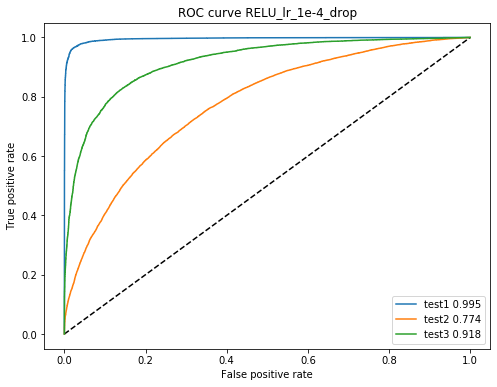

In [26]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [27]:
select_base_arch=create_base_network_drop_2(input_shape)
model=siamese_model(input_shape,select_base_arch)

model_name='RELU_lr_1e-3_drop'
# train
epochs = 200
lr = 1e-3
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 4s 65us/sample - loss: 0.0099 - accuracy: 0.9955 - val_loss: 0.0150 - val_accuracy: 0.9866
Epoch 89/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0100 - accuracy: 0.9954 - val_loss: 0.0142 - val_accuracy: 0.9877
Epoch 90/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0097 - accuracy: 0.9951 - val_loss: 0.0144 - val_accuracy: 0.9881
Epoch 91/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0095 - accuracy: 0.9955 - val_loss: 0.0142 - val_accuracy: 0.9888
Epoch 92/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0094 - accuracy: 0.9956 - val_loss: 0.0139 - val_accuracy: 0.9888
Epoch 93/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0093 - accuracy: 0.9959 - val_loss: 0.0140 - val_accuracy: 0.9885
Epoch 94/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0094 - accuracy: 0.995

60145/60145 [==============================] - 4s 64us/sample - loss: 0.0070 - accuracy: 0.9972 - val_loss: 0.0110 - val_accuracy: 0.9913
Epoch 143/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0070 - accuracy: 0.9971 - val_loss: 0.0119 - val_accuracy: 0.9906
Epoch 144/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0068 - accuracy: 0.9972 - val_loss: 0.0112 - val_accuracy: 0.9909
Epoch 145/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0069 - accuracy: 0.9973 - val_loss: 0.0117 - val_accuracy: 0.9909
Epoch 146/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0071 - accuracy: 0.9967 - val_loss: 0.0111 - val_accuracy: 0.9912
Epoch 147/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0068 - accuracy: 0.9972 - val_loss: 0.0119 - val_accuracy: 0.9904
Epoch 148/200
60145/60145 [==============================] - 4s 64us/sample - loss: 0.0070 - accuracy:

Tuning :RELU_lr_1e-3_drop


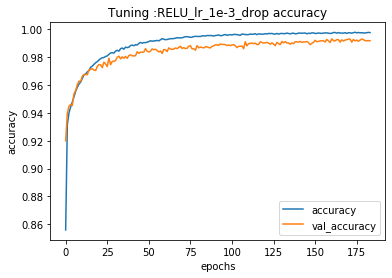

Tuning :RELU_lr_1e-3_drop
* Accuracy on test1 set: 95.61%
* Accuracy on test2 set: 65.24%
* Accuracy on test3 set: 81.19%
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      8238
           1       0.93      0.98      0.96      8238

    accuracy                           0.96     16476
   macro avg       0.96      0.96      0.96     16476
weighted avg       0.96      0.96      0.96     16476

              precision    recall  f1-score   support

           0       0.74      0.46      0.57     27996
           1       0.61      0.84      0.71     27996

    accuracy                           0.65     55992
   macro avg       0.68      0.65      0.64     55992
weighted avg       0.68      0.65      0.64     55992

Confusion Matrix
[[13013 14983]
 [ 4480 23516]]


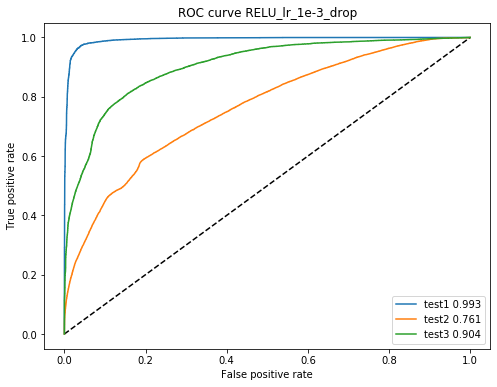

In [28]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [29]:
#diff activation fn

In [30]:
def create_base_network_leaky_relu(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(128, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [31]:
select_base_arch=create_base_network_leaky_relu(input_shape)
model=siamese_model(input_shape,select_base_arch)

model_name='Leaky_relu_lr_1e-4'
# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0   

60145/60145 [==============================] - 5s 84us/sample - loss: 0.0325 - accuracy: 0.9705 - val_loss: 0.0320 - val_accuracy: 0.9674
Epoch 89/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0323 - accuracy: 0.9702 - val_loss: 0.0319 - val_accuracy: 0.9676
Epoch 90/200
60145/60145 [==============================] - 5s 85us/sample - loss: 0.0322 - accuracy: 0.9708 - val_loss: 0.0319 - val_accuracy: 0.9691
Epoch 91/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0323 - accuracy: 0.9699 - val_loss: 0.0317 - val_accuracy: 0.9684
Epoch 92/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0320 - accuracy: 0.9708 - val_loss: 0.0316 - val_accuracy: 0.9687
Epoch 93/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0318 - accuracy: 0.9712 - val_loss: 0.0317 - val_accuracy: 0.9689
Epoch 94/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0319 - accuracy: 0.971

60145/60145 [==============================] - 5s 82us/sample - loss: 0.0280 - accuracy: 0.9776 - val_loss: 0.0290 - val_accuracy: 0.9721
Epoch 143/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0281 - accuracy: 0.9772 - val_loss: 0.0286 - val_accuracy: 0.9726
Epoch 144/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0279 - accuracy: 0.9770 - val_loss: 0.0291 - val_accuracy: 0.9713
Epoch 145/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0279 - accuracy: 0.9773 - val_loss: 0.0287 - val_accuracy: 0.9717
Epoch 146/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0280 - accuracy: 0.9773 - val_loss: 0.0286 - val_accuracy: 0.9717
Epoch 147/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0277 - accuracy: 0.9773 - val_loss: 0.0286 - val_accuracy: 0.9720
Epoch 148/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0276 - accuracy:

Epoch 196/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0254 - accuracy: 0.9818 - val_loss: 0.0270 - val_accuracy: 0.9737
Epoch 197/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0253 - accuracy: 0.9822 - val_loss: 0.0271 - val_accuracy: 0.9728
Epoch 198/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0254 - accuracy: 0.9817 - val_loss: 0.0271 - val_accuracy: 0.9727
Epoch 199/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0252 - accuracy: 0.9826 - val_loss: 0.0272 - val_accuracy: 0.9735
Epoch 200/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0253 - accuracy: 0.9822 - val_loss: 0.0270 - val_accuracy: 0.9738


Tuning :Leaky_relu_lr_1e-4


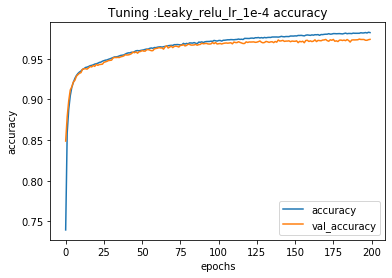

Tuning :Leaky_relu_lr_1e-4
* Accuracy on test1 set: 96.87%
* Accuracy on test2 set: 72.19%
* Accuracy on test3 set: 84.95%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8238
           1       0.97      0.97      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.76      0.64      0.70     27996
           1       0.69      0.80      0.74     27996

    accuracy                           0.72     55992
   macro avg       0.73      0.72      0.72     55992
weighted avg       0.73      0.72      0.72     55992

Confusion Matrix
[[17942 10054]
 [ 5516 22480]]


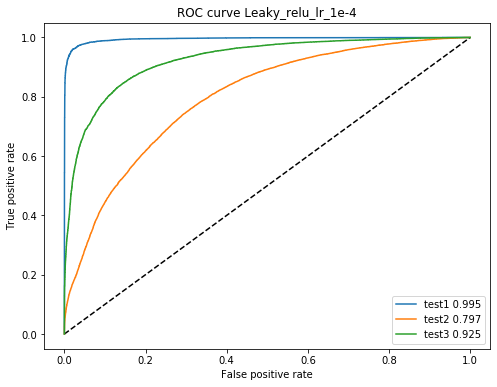

In [32]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [33]:
def create_base_network_elu(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.elu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.elu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.elu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.elu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(128, activation=tf.nn.elu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [34]:
select_base_arch=create_base_network_elu(input_shape)
model=siamese_model(input_shape,select_base_arch)

model_name='ELU_lr_1e-4'
# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0  

60145/60145 [==============================] - 4s 66us/sample - loss: 0.0488 - accuracy: 0.9544 - val_loss: 0.0480 - val_accuracy: 0.9474
Epoch 89/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0485 - accuracy: 0.9549 - val_loss: 0.0477 - val_accuracy: 0.9459
Epoch 90/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0484 - accuracy: 0.9549 - val_loss: 0.0476 - val_accuracy: 0.9469
Epoch 91/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0484 - accuracy: 0.9543 - val_loss: 0.0477 - val_accuracy: 0.9457
Epoch 92/200
60145/60145 [==============================] - 4s 66us/sample - loss: 0.0483 - accuracy: 0.9550 - val_loss: 0.0476 - val_accuracy: 0.9475
Epoch 93/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0480 - accuracy: 0.9555 - val_loss: 0.0473 - val_accuracy: 0.9476
Epoch 94/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0479 - accuracy: 0.955

60145/60145 [==============================] - 4s 69us/sample - loss: 0.0431 - accuracy: 0.9615 - val_loss: 0.0439 - val_accuracy: 0.9530
Epoch 143/200
60145/60145 [==============================] - 4s 68us/sample - loss: 0.0432 - accuracy: 0.9612 - val_loss: 0.0438 - val_accuracy: 0.9547
Epoch 144/200
60145/60145 [==============================] - 4s 68us/sample - loss: 0.0430 - accuracy: 0.9616 - val_loss: 0.0438 - val_accuracy: 0.9547
Epoch 145/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0427 - accuracy: 0.9620 - val_loss: 0.0441 - val_accuracy: 0.9533
Epoch 146/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0428 - accuracy: 0.9618 - val_loss: 0.0437 - val_accuracy: 0.9539
Epoch 147/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0428 - accuracy: 0.9623 - val_loss: 0.0437 - val_accuracy: 0.9544
Epoch 148/200
60145/60145 [==============================] - 4s 69us/sample - loss: 0.0427 - accuracy:

Epoch 196/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0400 - accuracy: 0.9659 - val_loss: 0.0420 - val_accuracy: 0.9577
Epoch 197/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0399 - accuracy: 0.9661 - val_loss: 0.0418 - val_accuracy: 0.9580
Epoch 198/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0398 - accuracy: 0.9665 - val_loss: 0.0419 - val_accuracy: 0.9560
Epoch 199/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0398 - accuracy: 0.9655 - val_loss: 0.0420 - val_accuracy: 0.9566
Epoch 200/200
60145/60145 [==============================] - 4s 67us/sample - loss: 0.0398 - accuracy: 0.9664 - val_loss: 0.0418 - val_accuracy: 0.9578


Tuning :ELU_lr_1e-4


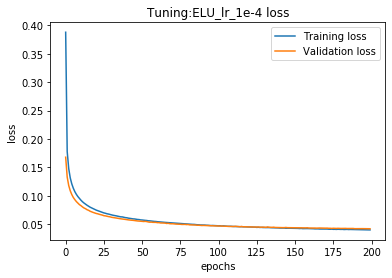

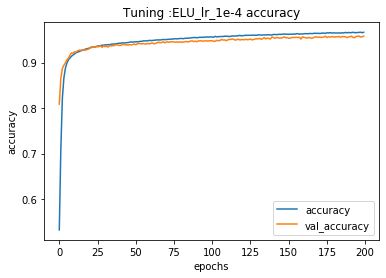

Tuning :ELU_lr_1e-4
* Accuracy on test1 set: 95.28%
* Accuracy on test2 set: 73.47%
* Accuracy on test3 set: 84.83%
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      8238
           1       0.96      0.95      0.95      8238

    accuracy                           0.95     16476
   macro avg       0.95      0.95      0.95     16476
weighted avg       0.95      0.95      0.95     16476

              precision    recall  f1-score   support

           0       0.75      0.70      0.72     27996
           1       0.72      0.77      0.74     27996

    accuracy                           0.73     55992
   macro avg       0.74      0.73      0.73     55992
weighted avg       0.74      0.73      0.73     55992

Confusion Matrix
[[19578  8418]
 [ 6435 21561]]


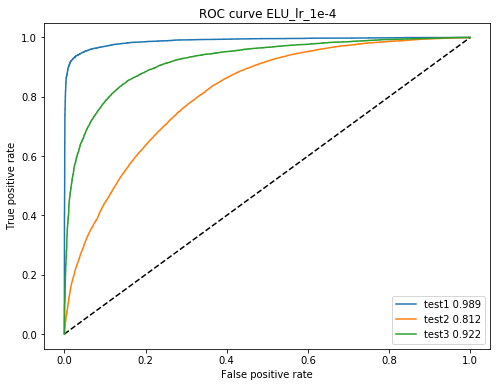

In [35]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [ ]:
#64

In [36]:
def create_base_network_leaky_relu_64(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(64, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [37]:
select_base_arch=create_base_network_leaky_relu_64(input_shape)
model=siamese_model(input_shape,select_base_arch)

model_name='Leaky_relu_lr_1e-4_dense_64'
# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0  

60145/60145 [==============================] - 5s 82us/sample - loss: 0.0337 - accuracy: 0.9682 - val_loss: 0.0326 - val_accuracy: 0.9669
Epoch 89/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0337 - accuracy: 0.9684 - val_loss: 0.0324 - val_accuracy: 0.9684
Epoch 90/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0335 - accuracy: 0.9686 - val_loss: 0.0327 - val_accuracy: 0.9657
Epoch 91/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0333 - accuracy: 0.9689 - val_loss: 0.0323 - val_accuracy: 0.9674
Epoch 92/200
60145/60145 [==============================] - 5s 81us/sample - loss: 0.0332 - accuracy: 0.9691 - val_loss: 0.0321 - val_accuracy: 0.9678
Epoch 93/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0332 - accuracy: 0.9694 - val_loss: 0.0321 - val_accuracy: 0.9673
Epoch 94/200
60145/60145 [==============================] - 5s 81us/sample - loss: 0.0332 - accuracy: 0.969

60145/60145 [==============================] - 5s 82us/sample - loss: 0.0291 - accuracy: 0.9755 - val_loss: 0.0290 - val_accuracy: 0.9736
Epoch 143/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0291 - accuracy: 0.9755 - val_loss: 0.0291 - val_accuracy: 0.9733
Epoch 144/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0292 - accuracy: 0.9753 - val_loss: 0.0292 - val_accuracy: 0.9715
Epoch 145/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0291 - accuracy: 0.9755 - val_loss: 0.0290 - val_accuracy: 0.9733
Epoch 146/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0289 - accuracy: 0.9752 - val_loss: 0.0290 - val_accuracy: 0.9737
Epoch 147/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0290 - accuracy: 0.9758 - val_loss: 0.0288 - val_accuracy: 0.9717
Epoch 148/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0288 - accuracy:

Epoch 196/200
60145/60145 [==============================] - 5s 85us/sample - loss: 0.0264 - accuracy: 0.9797 - val_loss: 0.0270 - val_accuracy: 0.9746
Epoch 197/200
60145/60145 [==============================] - 5s 85us/sample - loss: 0.0263 - accuracy: 0.9791 - val_loss: 0.0268 - val_accuracy: 0.9768
Epoch 198/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0263 - accuracy: 0.9798 - val_loss: 0.0270 - val_accuracy: 0.9767
Epoch 199/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0262 - accuracy: 0.9806 - val_loss: 0.0267 - val_accuracy: 0.9765
Epoch 200/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0261 - accuracy: 0.9802 - val_loss: 0.0269 - val_accuracy: 0.9757


Tuning :Leaky_relu_lr_1e-4_dense_64


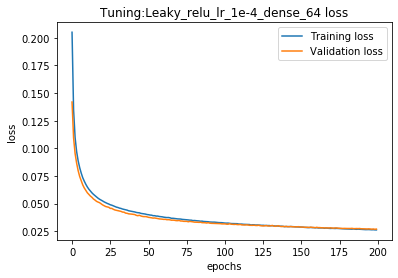

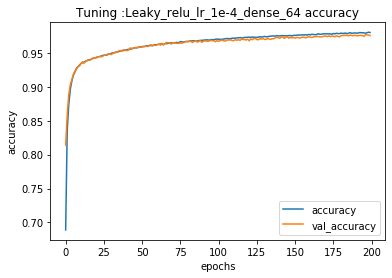

Tuning :Leaky_relu_lr_1e-4_dense_64
* Accuracy on test1 set: 97.06%
* Accuracy on test2 set: 72.30%
* Accuracy on test3 set: 85.23%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8238
           1       0.97      0.97      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.76      0.64      0.70     27996
           1       0.69      0.80      0.74     27996

    accuracy                           0.72     55992
   macro avg       0.73      0.72      0.72     55992
weighted avg       0.73      0.72      0.72     55992

Confusion Matrix
[[18031  9965]
 [ 5544 22452]]


In [38]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [39]:
def create_base_network_leaky_relu_256(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(256, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [40]:
select_base_arch=create_base_network_leaky_relu_64(input_shape)
model=siamese_model(input_shape,select_base_arch)

model_name='Leaky_relu_lr_1e-4_dense_256'
# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0  

60145/60145 [==============================] - 5s 84us/sample - loss: 0.0329 - accuracy: 0.9699 - val_loss: 0.0317 - val_accuracy: 0.9677
Epoch 89/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0327 - accuracy: 0.9697 - val_loss: 0.0316 - val_accuracy: 0.9670
Epoch 90/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0325 - accuracy: 0.9702 - val_loss: 0.0314 - val_accuracy: 0.9677
Epoch 91/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0324 - accuracy: 0.9707 - val_loss: 0.0314 - val_accuracy: 0.9674
Epoch 92/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0324 - accuracy: 0.9704 - val_loss: 0.0315 - val_accuracy: 0.9681
Epoch 93/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0323 - accuracy: 0.9706 - val_loss: 0.0312 - val_accuracy: 0.9686
Epoch 94/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0322 - accuracy: 0.970

60145/60145 [==============================] - 5s 84us/sample - loss: 0.0277 - accuracy: 0.9781 - val_loss: 0.0280 - val_accuracy: 0.9728
Epoch 143/200
60145/60145 [==============================] - 5s 86us/sample - loss: 0.0275 - accuracy: 0.9791 - val_loss: 0.0280 - val_accuracy: 0.9739
Epoch 144/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0275 - accuracy: 0.9788 - val_loss: 0.0280 - val_accuracy: 0.9743
Epoch 145/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0275 - accuracy: 0.9781 - val_loss: 0.0278 - val_accuracy: 0.9745
Epoch 146/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0274 - accuracy: 0.9779 - val_loss: 0.0278 - val_accuracy: 0.9750
Epoch 147/200
60145/60145 [==============================] - 5s 85us/sample - loss: 0.0272 - accuracy: 0.9784 - val_loss: 0.0280 - val_accuracy: 0.9744
Epoch 148/200
60145/60145 [==============================] - 5s 86us/sample - loss: 0.0273 - accuracy:

Epoch 196/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0246 - accuracy: 0.9827 - val_loss: 0.0260 - val_accuracy: 0.9777
Epoch 197/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0247 - accuracy: 0.9832 - val_loss: 0.0258 - val_accuracy: 0.9773
Epoch 198/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0245 - accuracy: 0.9836 - val_loss: 0.0258 - val_accuracy: 0.9780
Epoch 199/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0244 - accuracy: 0.9835 - val_loss: 0.0265 - val_accuracy: 0.9765
Epoch 200/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0247 - accuracy: 0.9832 - val_loss: 0.0257 - val_accuracy: 0.9771


Tuning :Leaky_relu_lr_1e-4_dense_256


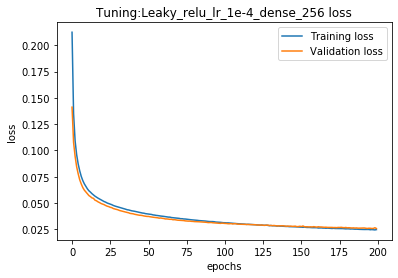

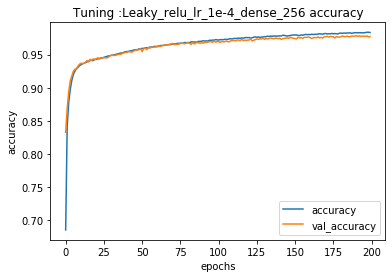

Tuning :Leaky_relu_lr_1e-4_dense_256
* Accuracy on test1 set: 96.97%
* Accuracy on test2 set: 72.35%
* Accuracy on test3 set: 85.28%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8238
           1       0.97      0.97      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.77      0.65      0.70     27996
           1       0.69      0.80      0.74     27996

    accuracy                           0.72     55992
   macro avg       0.73      0.72      0.72     55992
weighted avg       0.73      0.72      0.72     55992

Confusion Matrix
[[18064  9932]
 [ 5548 22448]]


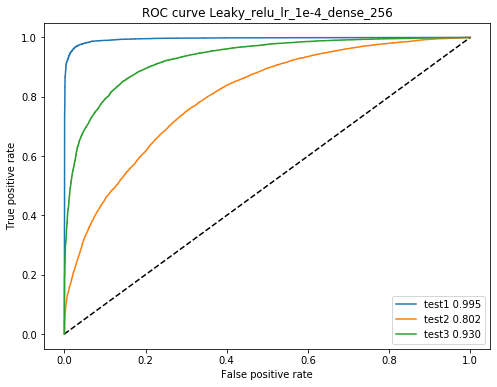

In [41]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)

In [42]:
def create_base_network_leaky_relu_512(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(512, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [43]:
select_base_arch=create_base_network_leaky_relu_64(input_shape)
model=siamese_model(input_shape,select_base_arch)

model_name='Leaky_relu_lr_1e-4_dense_512'
# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0  

60145/60145 [==============================] - 5s 83us/sample - loss: 0.0337 - accuracy: 0.9680 - val_loss: 0.0321 - val_accuracy: 0.9666
Epoch 89/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0335 - accuracy: 0.9683 - val_loss: 0.0321 - val_accuracy: 0.9646
Epoch 90/200
60145/60145 [==============================] - 5s 84us/sample - loss: 0.0334 - accuracy: 0.9691 - val_loss: 0.0318 - val_accuracy: 0.9667
Epoch 91/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0334 - accuracy: 0.9683 - val_loss: 0.0321 - val_accuracy: 0.9666
Epoch 92/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0333 - accuracy: 0.9687 - val_loss: 0.0317 - val_accuracy: 0.9662
Epoch 93/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0331 - accuracy: 0.9696 - val_loss: 0.0315 - val_accuracy: 0.9656
Epoch 94/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0331 - accuracy: 0.968

60145/60145 [==============================] - 5s 82us/sample - loss: 0.0292 - accuracy: 0.9752 - val_loss: 0.0288 - val_accuracy: 0.9711
Epoch 143/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0292 - accuracy: 0.9756 - val_loss: 0.0286 - val_accuracy: 0.9713
Epoch 144/200
60145/60145 [==============================] - 5s 85us/sample - loss: 0.0290 - accuracy: 0.9759 - val_loss: 0.0287 - val_accuracy: 0.9716
Epoch 145/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0291 - accuracy: 0.9757 - val_loss: 0.0286 - val_accuracy: 0.9718
Epoch 146/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0291 - accuracy: 0.9757 - val_loss: 0.0285 - val_accuracy: 0.9721
Epoch 147/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0289 - accuracy: 0.9759 - val_loss: 0.0286 - val_accuracy: 0.9720
Epoch 148/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0288 - accuracy:

Epoch 196/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0267 - accuracy: 0.9797 - val_loss: 0.0272 - val_accuracy: 0.9731
Epoch 197/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0266 - accuracy: 0.9798 - val_loss: 0.0271 - val_accuracy: 0.9729
Epoch 198/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0267 - accuracy: 0.9796 - val_loss: 0.0270 - val_accuracy: 0.9732
Epoch 199/200
60145/60145 [==============================] - 5s 82us/sample - loss: 0.0266 - accuracy: 0.9793 - val_loss: 0.0269 - val_accuracy: 0.9733
Epoch 200/200
60145/60145 [==============================] - 5s 83us/sample - loss: 0.0264 - accuracy: 0.9795 - val_loss: 0.0269 - val_accuracy: 0.9721


Tuning :Leaky_relu_lr_1e-4_dense_512


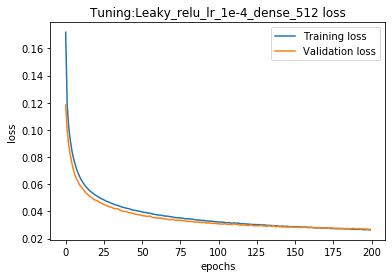

Tuning :Leaky_relu_lr_1e-4_dense_512
* Accuracy on test1 set: 96.89%
* Accuracy on test2 set: 71.32%
* Accuracy on test3 set: 84.75%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8238
           1       0.97      0.97      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476

              precision    recall  f1-score   support

           0       0.77      0.61      0.68     27996
           1       0.68      0.81      0.74     27996

    accuracy                           0.71     55992
   macro avg       0.72      0.71      0.71     55992
weighted avg       0.72      0.71      0.71     55992

Confusion Matrix
[[17207 10789]
 [ 5269 22727]]


In [44]:
plot_loss_accuracy(history, model_name)
evaluate_test_accuracy_roc(model, model_name, test_x1, test_x2, test_x3, test_y1, test_y2, test_y3)